In [156]:
% matplotlib inline
from myst_nb import glue

(chap-pythongis)=
# Aufgabe 13: GIS in Python

## Theorie

Bevor wir uns an den **Schritt 4** in unserer Monte Carlo Simulation ({numref}`monte-carlo-workflow`) machen können müssen wir uns noch mit einem Thema konkret befassen, welches wir bisher vernachlässigt haben. Manche mag das jetzt überraschen, andere haben es vielleicht schon gemerkt. Mit **GIS** hatte unseres bisheriges Wirken in Python eigentlich wenig zu tun. Unsere Zeckenstiche haben zwar x/y-Koordinaten, aber diese haben wir bisher gleich behandlet wie alle anderen Spalten.

Anders gesagt: *Wir* wissen ja, dass mit den Spalten `x` und `y` Koordinaten in der Schweiz gemeint sind, Python hingegen wusste das bisher (noch) nicht. Der konkrete Raumbezug fehlt also noch, und das wird irgendwann problematisch: Denn wir wollen in **Schritt 4** ({numref}`monte-carlo-workflow`) pro Zeckenstich ermitteln, ob er sich im Wald befindet oder nicht. Das ist eine explizit räumliche Abfrage, welche nur mit explizit räumlichen Geodaten beantwortet werden kann.

In [3]:
# Unsere Zeckenstiche hatten wir auf folgende Weise importiert:
    
import pandas as pd
zeckenstiche = pd.read_csv("zeckenstiche.csv")
zeckenstiche

,ID,accuracy,x,y
0,2550,439.128951,2681116,1250648
1,10437,301.748542,2681092,1250672
2,9174,301.748542,2681128,1250683
3,8773,301.748542,2681111,1250683
4,2764,301.748529,2681131,1250692
5,2513,301.748529,2681171,1250711
6,9185,301.748542,2681107,1250712
7,28521,301.748542,2681124,1250720
8,26745,301.748542,2681117,1250725
9,27391,301.748542,2681138,1250725


### GeoDataFrames

Glücklicherweise können wir unsere Zeckenstich-*Dataframe* mit nur einem Zusatzmodul und wenigen Zeilen code in eine **räumliche** *DataFrame* konvertieren. Mit dem Modul ***geo**pandas* erstellen wir aus unserer *pandas DataFrame* eine ***geo**pandas **Geo**DataFrame*. Mit dieser Erweiterung erhält die *DataFrame* im Wesentlichen:

- eine Zusatzspalte `geometry` mit der Geometrie als räumliches Objekt
- ein Attribut `crs` welches das Koordinatensystem der Geometriespalte enthält. 

Beides müssen wir bei der Erstellung der *GeoDataFrame* aber festlegen. 

Bei `geometry` handelt es sich Punkt-Geometrien die sich duch die `x` und `y` Koordinaten zusammensetzen. Für das Attribut `crs` möchte ich kurz etwas ausholen:

### Koordinatensystem

Das Koordinatensystem gibt unseren x/y-Zahlenwerten einen konkreten Raumbezug auf dem Planeten. Sie macht aus ihnen Koordianten *in der Schweiz*. Wie lautet aber das "Koordinatensystem" unserer Daten? 

Das ist Information, welche euch vom Datenersteller geliefert werden muss. Man man das Koordinatensytem aber auch anhand der Koordinaten erahnen. Es handelt sich dabei um Werte im Bereich von 2.6 Mio auf der einen und 1.2 Mio auf der anderen Achse. Da wir wissen das die Daten aus der Schweiz stammen kann man mit etwas Erfahrung sagen, dass es sich um Daten im neuen Schweizer Koordinatensystem [CH1903+ / LV95](https://epsg.io/2056) handeln muss. Der EPSG Code dieses Koordinatensystems lautet 2056 und diesen Code können wir in der Funktion `gpd.GeoDataFrame` nutzuen, um das Korrekte Koordinatensystem (engl. **C**oordinate **R**eference **S**ystem) zu zuweisen (s.u.)

In [4]:
import geopandas as gpd

zeckenstiche_gpd = gpd.GeoDataFrame(zeckenstiche, # die Basis-DataFrame / die "Attributtabelle"
                                    # die Geometrie Spalte:
                                    geometry=gpd.points_from_xy(zeckenstiche['x'], zeckenstiche['y']),
                                    crs = 2056) # EPSG Code des Koorinatensystem
zeckenstiche_gpd

,ID,accuracy,x,y,geometry
0,2550,439.128951,2681116,1250648,POINT (2681116.000 1250648.000)
1,10437,301.748542,2681092,1250672,POINT (2681092.000 1250672.000)
2,9174,301.748542,2681128,1250683,POINT (2681128.000 1250683.000)
3,8773,301.748542,2681111,1250683,POINT (2681111.000 1250683.000)
4,2764,301.748529,2681131,1250692,POINT (2681131.000 1250692.000)
5,2513,301.748529,2681171,1250711,POINT (2681171.000 1250711.000)
6,9185,301.748542,2681107,1250712,POINT (2681107.000 1250712.000)
7,28521,301.748542,2681124,1250720,POINT (2681124.000 1250720.000)
8,26745,301.748542,2681117,1250725,POINT (2681117.000 1250725.000)
9,27391,301.748542,2681138,1250725,POINT (2681138.000 1250725.000)


In [5]:
type(zeckenstiche_gpd)

geopandas.geodataframe.GeoDataFrame

In [6]:
# Vergleich mit "zeckenstiche"
type(zeckenstiche)

pandas.core.frame.DataFrame

In [320]:
# Das Attribut `crs` wurde aufgrund vom EPSG Code richtig erkannt:
zeckenstiche_gpd.crs.name

'CH1903+ / LV95'

(chap-raeumliche-operationen)=
### Räumliche Operationen

Was hat das nun bewirkt, was bringt uns diese *Geo* Erweiterung? Ein kleiner, aber offensichlicher Vorteil ist das veränderte Verhalten von der `.plot()` Methode. Da `zeckenstiche_gpd` ein räumliches Objekt ist, macht `.plot()` automatisch einen räumliche Darstellung der Daten, `.plot.scatter(...)` ist also nicht mehr nötig, wie es [vorher](ex-scatterplot) der Fall war [^ax-equal].

[^ax-equal]: Zudem sorgt `.plot` auch dafür, dass die beiden Achsen gleich skaliert sind. So ist`fig.axis("equal")` nicht mehr nötig wie es im Scatterplot in der {ref}`ex-scatterplot` der Fall war.

Die Vorteile geht aber noch viel weiter. Mit *GeoPandas* sind nun auch räumliche Operationen möglich, die wir bereits aus ArcGIS kennen aber mit einfachen *DataFrames* noch nicht möglich waren. Mit `.buffer()` können wir zum Beispiel einen Buffer um unsere Punkte machen.

<AxesSubplot:>

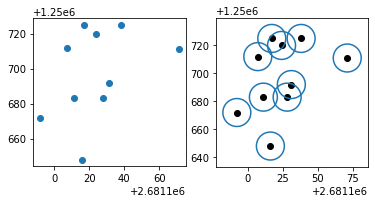

In [242]:
from matplotlib import pyplot as plt   # dieser Teil wird nur benötigt, weil die beiden
fig, (ax1, ax2) = plt.subplots(1, 2)   # Plots nebeinenader stehen sollen

zeckenstiche_gpd.plot(ax = ax1)        # "ax = ax1" kann auch weggelassen weren

buffered = zeckenstiche_gpd.buffer(10) # macht ein Buffer mit 10m Distanz
buffered.boundary.plot(ax = ax2)       # mit .boundary erhalte ich die Polygonumrisse
zeckenstiche_gpd.plot(ax = ax2, color = "black") 

Im Prinzip stehen uns jetzt auch alle anderen Vektor Operationen zur Verfügung, die wir schon aus ArcGIS kennen. Mit `unary_union` [^union] können wir aus unseren Einzelpunkten ein *Multipolygon* erstellen und darüber ein *Convex Hull* [^convex-hull] oder ein *Envelope* [^envelope] rechnen.

[^union]: Dieser Befehl lautet in ArcGIS [Union](https://desktop.arcgis.com/de/arcmap/10.3/tools/analysis-toolbox/union.htm)
[^convex-hull]: Convex Hull (Konvexe Hülle) ist eine "Rahmen" um alle Punkte, wo die Innenwinkel immer kleiner sind als 180°). Dieser Befehl lautet in ArcGIS [Minimum Bounding Geometry](https://pro.arcgis.com/de/pro-app/tool-reference/data-management/minimum-bounding-geometry.htm) (Option *Convex Hull*)
[^envelope]: Envelope ist ebenfalls ein "Rahmen" um alle Punkte, was aber quadratisch und am Koordinatensystem orientiert ist. Auch diese Operation lautet in ArcGIS unter dem Tool [Minimum Bounding Geometry](https://pro.arcgis.com/de/pro-app/tool-reference/data-management/minimum-bounding-geometry.htm) (Option *Envelope*)

<AxesSubplot:>

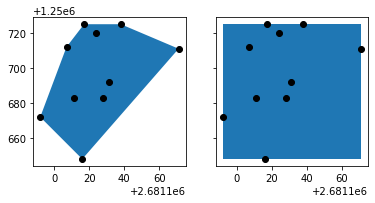

In [323]:
# Macht ein Union der Zeckenstiche (ein Multipoint-Objekt)
# (dies ist nötig, weil convex_hull / envelope Multipoint Objekte benötigen)
zeckenstiche_union = zeckenstiche_gpd["geometry"].unary_union

# Berechnet den Convex Hull und speichert den Ouput als Polygon
my_convex_hull = zeckenstiche_union.convex_hull

# Konvertiert das Polygon in eine GeoSeries
# (GeoSeries sind praktischer als Polygone)
my_convex_hull = gpd.GeoSeries(my_convex_hull)

# Berechnet das Envelope und speichert den Output als Polygon
my_envelope = zeckenstiche_union.envelope

# Konvertiert das Polygon in eine GeoSeries
# (GeoSeries sind praktischer als Polygone)
my_envelope = gpd.GeoSeries(my_envelope)

# Bereitet wieder die beiden Subplots vor
fig, (ax1, ax2) = plt.subplots(1, 2,sharex=True, sharey = True)

# Erstellt den linken Plot
my_convex_hull.plot(ax = ax1)
zeckenstiche_gpd.plot(ax = ax1, color = "black")

# Erstellt den rechten Plot
my_envelope.plot(ax = ax2)
zeckenstiche_gpd.plot(ax = ax2, color = "black")

````{admonition} Wichtig!
:class: attention
Geopandas kennt drei Fundamentale Datentypen: 

- **Geometrien**: Einzelne Objekte [^shapely] der folgenden Typen
  - Points / Multi-Points
  - Lines / Multi-Lines
  - Polygons / Multi-Polygons
- **GeoSeries**: Eine Serie von Geometrien, gleichbedeutend wie eine Spalte in einer Tabelle
- **GeoDataFrame**: Eine Tabelle, welche über eine Geometrie-Spalte (GeoSeries) verfügt

```{figure} Geopandas_types.jpg
---
name: geopandas-types
---
Die drei Datentypen in Geopandas.
```

[^shapely]: Die Geometrien in Geopandas sind eigentlich Objekte vom Modul [*Shapely*](https://pypi.org/project/Shapely/). Shapely wiederum ist ein Python Modul, welches mit *Geopandas* mit-installiert und mit-importiert wird.

Die verschiedenen Operationen in Geopandas erwarten teilweise unterschiedlichen Input, deshalb müssen wir teilweise zwischen *Geometrien*, *Geoseries* und *GeoDataFrames* hin- und her konvertieren. Geopandas ist noch in Arbeit und ich hoffe, dass das Package in der Zukunft noch etwas einfacher in der Handhabung wird. 

Aktuell brauchen zum Beispiel `unary_union`, `convex_hull` und `envelope` alle *GeoSeries* als Input. Der Output den drei Operationen ist jedoch eine *Geometrie*. Die Operation `buffer` nimmt sowohl ganze *GeoDataFrames* wie auch *GeoSeries* als Input an. Die Overlay Operationen mit `overlay` funktionieren aktuell nur mit "GeoDataFrames". 

*Geopandas* ist aber gut dokumentiert, und es lohnt sich bei Unklarheiten immer das Handbuch zu konsultieren: [geopandas.org](https://geopandas.org). Zudem hilft es, die Datentypen regelmässig mit `type` zu kontrollieren.
````

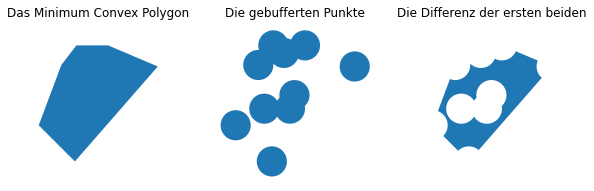

In [282]:
#################################################
# Diese Code ist nur nötig, weil die Overlay
# Operationen GeoDataFrames als Input benötigen.
buffered_gdf = gpd.GeoDataFrame(geometry = buffered, crs = 2056)               
my_convex_hull_gdf = gpd.GeoDataFrame(geometry = my_convex_hull, crs = 2056) 
#################################################

# Bereitet die drei Subplots vor:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey = True, figsize = (10,8))

#################################################
my_convex_hull_gdf.plot(ax = ax1)               #
ax1.set_title("Das Minimum Convex Polygon")     # Plot links
ax1.set_axis_off()                              #
#################################################
buffered_gdf.plot(ax = ax2)                     #
ax2.set_title("Die gebufferten Punkte")         # Plot mitte
ax2.set_axis_off()                              #
#################################################

# Overlay Operation
my_difference = gpd.overlay(my_convex_hull_gdf,buffered_gdf, how='difference')

#################################################
my_difference.plot(ax = ax3)                    #
ax3.set_title("Die Differenz der ersten beiden")# # Plot rechts
ax3.set_axis_off()                              #
#################################################

## Übungen

% *DataFrame* zu *GeoDataFrame*
### Übung 13.1

Importiere *Geopandas* und wandle `zeckenstiche` in eine *GeoDataFrame* um (`zeckenstiche_gpd`). Vergiss nicht, das Koordinatensystem festzulegen!

In [210]:
# Musterlösung

import geopandas as gpd

zeckenstiche_gpd = gpd.GeoDataFrame(zeckenstiche, geometry=gpd.points_from_xy(zeckenstiche['x'], zeckenstiche['y'], crs = 2056))

% Punkte Buffern
### Übung 13.2

Buffere die Zeckenstiche um eine Distanz von 12 Meter und speichere den Output in der Variabel `zeckenstiche_buffer`. Visualisiere die gebufferten Punkte in einem Plot.

<AxesSubplot:>

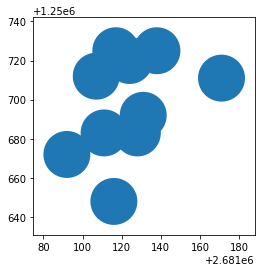

In [240]:
# Musterlösung

zeckenstiche_buffer = zeckenstiche_gpd.buffer(12)
zeckenstiche_buffer.plot()

% : Umrisse visualisieren
### Übung 13.3

Extrahiere die Umrisse von `zeckenstiche_buffer` und speichere diese in `zeckenstiche_buffer_outline`. Visualisiere anschliessend diese Umrisse.

In [246]:
# Musterlösung

zeckenstiche_buffer_outline = zeckenstiche_buffer.boundary

<AxesSubplot:>

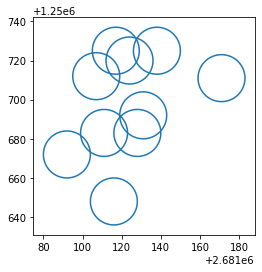

In [247]:
zeckenstiche_buffer_outline.plot()

% : Layers überlagern
### Übung 13.4

Nutze nachstehenden Code um zwei Datensätze im gleichen Plot darzustellen. 

<AxesSubplot:>

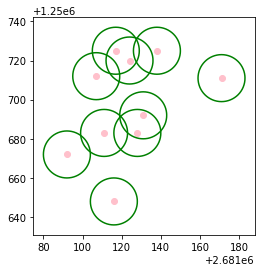

In [254]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

zeckenstiche_buffer_outline.plot(ax = ax, color = "green")
zeckenstiche_gpd.plot(ax = ax, color = "pink")

% Envelope
### Übung 13.5

Berechne das "Envelope" von `zeckenstiche_gpd` anhand der obigen Beispielen. Speichere den Output als `zeckenstiche_envelope`.

```{tip}
:class: dropdown
Denk daran, dass du zuerst noch einen Union machen musst (siehe {ref}`chap-raeumliche-operationen`)
```


In [302]:
# Musterlösung

zeckenstiche_envelope = zeckenstiche_gpd.unary_union.envelope

% Overlay Operation
### Übung 13.6

Führe verschiedene Overlay Operationen zwischen `zeckenstiche_envelope` und `zeckenstiche_buffer` durch. Schaue dir dazu die entsprechende [Geopandas Hilfeseite](https://geopandas.org/set_operations.html#set-operations-with-overlay) an. Beispielsweise würden sich *Union* und *Symetrical Difference* gut anbieten.

```{tip}
:class: dropdown
- `zeckenstiche_envelope` musst zu zuerst noch in eine GeoSeries umwandeln. Den Ouput davon kannst du in eine GeoDataFrame konvertieren
- `zeckenstiche_buffer` sollte schon eine GeoSeries sein, diese kannst du direkt in eine GeoDataFrame konvertieren
- beim Konvertieren in eine GeoDataFrame kannst du jeweils direkt das Koordinatensystem (`crs = `) korrekt setzen. 
```

In [310]:
# Musterlösung

zeckenstiche_buffer_gdf = gpd.GeoDataFrame(geometry = zeckenstiche_buffer, crs = 2056)

zeckenstiche_envelope_gdf = gpd.GeoDataFrame(geometry = gpd.GeoSeries(zeckenstiche_envelope), crs = 2056)

my_union = gpd.overlay(zeckenstiche_envelope_gdf, zeckenstiche_buffer_gdf, how = "union")

my_symmdiff = gpd.overlay(zeckenstiche_envelope_gdf, zeckenstiche_buffer_gdf, how = "symmetric_difference")


Text(0.5, 1.0, 'Symetrical Difference')

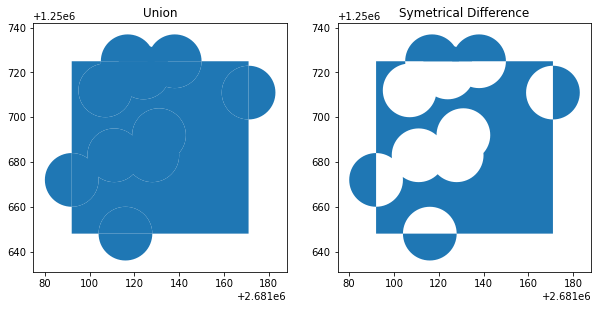

In [318]:
# Das Resultat sollte folgendermassen aussehen

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,8))

my_union.plot(ax = ax1)
ax1.set_title("Union")
my_symmdiff.plot(ax = ax2)
ax2.set_title("Symetrical Difference")

DIESER TEIL IST VOM DOKUMENT ENTFERNT

% Geopandas als Shapefile / Geopackage abspeichern
### Übung 13.7

Jetzt wo wir unsere Zeckenstiche als Geodaten aufbereitet haben können wir diese auch in gängige Geodaten abspeichern. Genau wie wir in {ref}`ex-to-csv` eine *DataFrame* mit `.to_csv` in eine csv exportiert haben, gibt es für GeoDataFrames die Methode `.to_file`. Exportiere `zeckenstiche_gpd` mit dieser Methode in eine Shapefile.

**Zusatzaufgabe**: Shapefiles sind eigentlich ein ganz schreckliches Format (siehe [switchfromshapefile.org](http://switchfromshapefile.org/)). Viel praktischer sind an dieser Stelle *Geopackages* (nicht zu verwechseln mit ArcGIS Pro Packages). Ihr könnt `monte_carlo_df` auch als *Geopackage* exportieren, dafür müsst ihr dem Output die Erweiterung "gpkg" geben und zusätzlich `driver = GPKG` festlegen.

```python
# Lösung

zeckenstiche_gpd.to_file("zeckenstiche.shp")

zeckenstiche_gpd.to_file("zeckenstiche.gpkg", driver = "GPKG")
```

### Übung 13.7

Lade [hier das File "wald.gpgk"](https://github.com/ratnanil/codingingis/raw/master/wald.gpkg) herunter (Rechtsklick > Speichern unter) uns speichere es in deiner Workings Directory. Importiere den Datensatz mit `gpd.read_file("wald.gpkg")` und speichere ihn in der Variable `wald`. 

Schau dir `wald`an (`type`, `.plot()` etc.)

In [8]:
# Musterlösung

wald = gpd.read_file("wald.gpkg")

wald
type(wald)
wald.plot()

<AxesSubplot:>